In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12,8

In [2]:
import os
import sys
import numpy as np
from astropy.time import Time
import astropy.coordinates
from myPyLib.Mollweide import moll
#from matplotlib import pyplot as plt
import util
import schdutil
import Moon


In [3]:
tel, yr, mn, dy = 'bok', 2016, 9, 3
moon_dis_limit = 50.0
moon_dis_limit, airmass_limit, ha_limit=50.0,1.75,3.0
obs_begin, obs_end = None, None
# airmass lower limit, set this to avoid zenith
airmass_lbound = 1.005  # about 84 deg


In [4]:
    # load site and telescope basic data
    site = schdutil.load_basic(tel)

    # load fields and plan
    plans  = schdutil.load_expplan(tel)
    fields = schdutil.load_field(tel)
    plancode = plans.keys()
    plancode.sort()
    nplan = len(plancode)


In [5]:
    # night parameters
    # mjd of 18:00 of site timezone, as code of tonight
    mjd18 = int(schdutil.mjd(yr, mn, dy, 18, 0, 0, site.tz)) % 10000
    # mjd of local midnight, as calculate center
    mjd24 = schdutil.mjd(yr, mn, dy, 24 - site.lon / 15.0, 0, 0,  0)
    tmjd24 = Time(mjd24, format="mjd")
    # night length (hour)
    night_len = schdutil.night_len(mjd24, site.lat)
    dark_len = night_len - 2.5  # assume twilight 1.25 hours
    # local sidereal time of midnight
    lst24 = schdutil.fmst (yr, mn, dy, site.lon)
    # timezone correction: between local time and timezone standard time
    tzcorr = site.tz - site.lon / 15.0
    # observation start and end time, in timezone time
    sunset_time, sunrise_time = 24 + tzcorr - night_len / 2, 24 + tzcorr + night_len / 2
    # if obs time is given, use given time
    if obs_begin is None :
        obs_begin = 24 + tzcorr - dark_len / 2
    else :
        if obs_begin < 12.0 : obs_begin += 24
    if obs_end is None :
        obs_end = 24 + tzcorr + dark_len / 2
    else :
        if obs_end < 12.0 : obs_end += 24
    # moon position at midnight, as mean coord to calculate moon-object distance
    mpos = astropy.coordinates.get_moon(tmjd24)
    mphase = Moon.moon_phase(tmjd24)
    # sun position at midnight
    spos = astropy.coordinates.get_sun(tmjd24)


In [6]:
    # find all obsed file, and mark them
    obsedlist = schdutil.ls_files("{tel}/obsed/*/obsed.J*.lst".format(tel=tel))
    schdutil.load_obsed(fields, obsedlist, [], plancode, None)
    afields = np.array(fields.values())
    ara = np.array([f.ra for f in afields])
    ade = np.array([f.de for f in afields])

In [7]:
    # mark fields near moon and sun
    moon_dis = Moon.distance(mpos.ra.deg, mpos.dec.deg, ara, ade)
    for f in afields[np.where(moon_dis < moon_dis_limit)]:
        f.tag += 10
    sun_dis = Moon.distance(spos.ra.deg, spos.dec.deg, ara, ade)
    for f in afields[np.where(sun_dis < 75)]:
        f.tag += 20
    atag = np.array([f.tag for f in afields])


In [8]:
    # keep only unfinished fields, and must away from moon
    newfield = afields[np.where(atag <= 1)]

    # count histogram
    n_tag = len(afields)
    n_tag_01 = sum(atag <= 1)
    n_tag_2  = sum(atag % 10 == 2)
    n_tag_10 = sum((atag % 10 <= 1) & (atag >= 10))


In [9]:
    # blocks and unique blocks
    newfieldblock = np.array([f.bk for f in newfield])
    newblockset = set(newfieldblock)
    n_block = len(newblockset)

In [12]:
newfieldblock

array(['-110029', '-110029', '-110029', ..., '8852922', '8852922',
       '8852922'], 
      dtype='|S7')

In [13]:
    # block parameter
    newblock = {}
    for b in newblockset :
        f_in_b = newfield[np.where(newfieldblock == b)]
        newblock[b] = schdutil.block_info(b, f_in_b)

In [10]:
    clock_now = obs_begin
    lst_now = lambda : (lst24 + clock_now) % 24.0  # lst of start, use lst_now() to call this

    # define a lambda rank function
    rank = lambda aa : aa.argsort().argsort()


In [ ]:
    block_sn = 0  # block sn, count blocks, and also for output
    time_skip = 0 # skipped time, sum when no good block available
    span_skip = 1.0 / 60.0 # how long skipped each loop

In [71]:
    rep_fmt = "{sn:02}: #{bn} ({ra:9.5f} {de:+9.5f}) {airm:4.1f} @ {clock:5}".format
    sum_fmt = "{clock:5}: {sn:02} #{bn} ({ra:9.5f} {de:+9.5f}) {airm:4.1f}\n".format
    chk_fmt = "{ord:04} {bn} ({ra:9.5f} {de:+9.5f}) {airm:4.2f} {key:>5.1f}\n".format
    scr_fmt = (site.fmt + "\n").format


## inside the loop colck_now < obs_end

In [61]:
        bra = np.array([b.ra for b in newblock.values()])
        bde = np.array([b.de for b in newblock.values()])
        bname = np.array(newblock.keys())


In [62]:
        # calculate airmass for all available block
        ha = np.abs(lst_now() - bra) / 15.0
        airm = schdutil.airmass(site.lat, lst_now(), bra, bde)


(array([   0.,    0.,    0.,    0.,    0.,  328.,  151.,   81.,   47.,   43.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

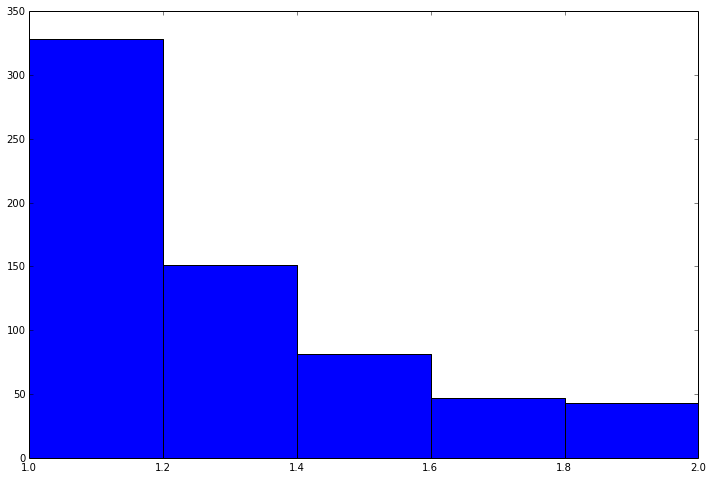

In [15]:
plt.hist(airm, range=(0,2))

In [63]:
        ix_1 = np.where((airm < airmass_limit) & (airm > airmass_lbound) &
                        ((ha < ha_limit) | (ha > 24.0 - ha_limit)))


In [64]:
        minde = bde[ix_1].min()
        ix_2 = np.where((airm < airmass_limit) & (airm > airmass_lbound) &
                        ((ha < ha_limit) | (ha > 24.0 - ha_limit)) &
                        (bde < minde + 4.0))
        len(ix_2[0])

42

In [65]:
        # make key for each block, key = airmass rank + ra rank + de rank
        airm_2, bra_2, bde_2, bname_2 = airm[ix_2], bra[ix_2], bde[ix_2], bname[ix_2]
        rank_2 = rank(airm_2) + rank(bra_2)/2.0 + rank(bde_2)/2.0
rank_2

array([ 59. ,  35.5,  42.5,  43. ,  39. ,  42. ,  47. ,  36.5,  49. ,
        36.5,  38. ,  38. ,  53.5,  30. ,  48. ,  49.5,  50.5,  42.5,
        40. ,  33. ,  49.5,  34. ,  53. ,  28.5,  43. ,  37. ,  37.5,
        45.5,  39. ,  43.5,  42.5,  45. ,  41. ,  29. ,  45. ,  33. ,
        32. ,  34.5,  41.5,  43.5,  36. ,  35.5])

(0, 4)

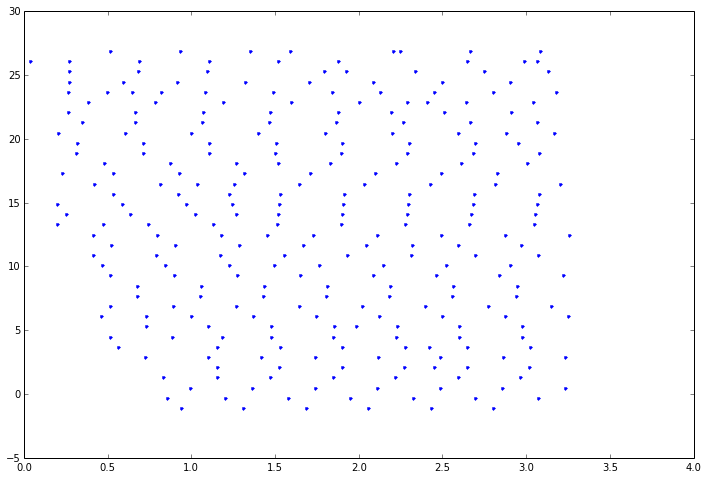

In [66]:
plt.plot(bra[ix_1]/15.0,bde[ix_1],".")
plt.xlim(0,4)

In [67]:
lst_now(), clock_now

(3.9248209806137737, 20.169593967152693)

(array([ 246.,  233.,   98.,  227.,  232.,   30.,   12.,   21.,  126.,  223.]),
 array([  9.74334626e-04,   2.35600816e+00,   4.71104199e+00,
          7.06607582e+00,   9.42110965e+00,   1.17761435e+01,
          1.41311773e+01,   1.64862111e+01,   1.88412450e+01,
          2.11962788e+01,   2.35513126e+01]),
 <a list of 10 Patch objects>)

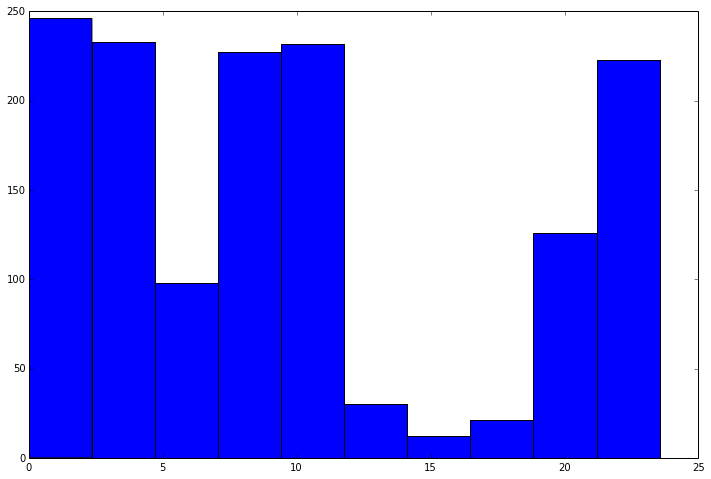

In [68]:
plt.hist(ha)

In [69]:
        # choose the best block, and generate scripts, and generate check file
        sort_2 = rank_2.argsort() # sort for generate check file
        ix_best = rank_2.argmin() # the best block
        bname_best = bname_2[ix_best]
        block_best = newblock[bname_best]
        # inc sn
        block_sn += 1


In [72]:
            print("#{ord:>3} {bn:>7} ({ra:^9} {de:^9}) {airm:>4} {key:>5}\n".format(
                ord="ORD",bn="B_NAME", ra="RA", de="DEC", airm="AIRM",key="KEY")).strip()
            for i in range(len(ix_2[0])) :
                s = sort_2[i]
                b = newblock[bname_2[s]]
                print(chk_fmt(ord=i+1, bn=b.bname, ra=b.ra, de=b.de, airm=airm_2[s], key=rank_2[s])).strip()


#ORD  B_NAME (   RA        DEC   ) AIRM   KEY
0001 -033253 ( 46.05063  -0.30000) 1.21  28.5
0002 -110421 ( 42.05775  -1.10000) 1.25  29.0
0003 0130421 ( 48.45184  +0.50000) 1.19  30.0
0004 -110365 ( 36.45672  -1.10000) 1.29  32.0
0005 -033197 ( 40.45055  -0.30000) 1.25  33.0
0006 -110309 ( 30.85569  -1.10000) 1.35  33.0
0007 0130365 ( 42.85163  +0.50000) 1.22  34.0
0008 0370357 ( 45.28041  +2.10000) 1.19  34.5
0009 -033141 ( 34.85048  -0.30000) 1.30  35.5
0010 0213207 ( 44.46144  +1.30000) 1.20  35.5
0011 0213151 ( 38.86000  +1.30000) 1.24  36.0
0012 0130309 ( 37.25142  +0.50000) 1.26  36.5
0013 0130253 ( 31.65121  +0.50000) 1.32  36.5
0014 -033085 ( 29.25040  -0.30000) 1.36  37.0
0015 -110253 ( 25.25465  -1.10000) 1.44  37.5
0016 0370301 ( 39.67665  +2.10000) 1.22  38.0
0017 0453222 ( 48.51213  +2.90000) 1.16  38.0
0018 0453166 ( 42.90495  +2.90000) 1.19  39.0
0019 0370021 ( 36.70322  +2.10000) 1.24  39.0
0020 0213095 ( 33.25856  +1.30000) 1.29  40.0
0021 -110197 ( 19.65362  -1.10000)

In [73]:
        block_time = 0  # time cost for this block, in seconds
        #with open(scr_fn, "w") as scr_f :
        if True:
            # script: plan loop, field loop, do only factor < 1
            for p in plancode :
                for f in block_best.fields :
                    factor_work = 1.0 - f.factor[p]
                    nrepeat = int(np.ceil(factor_work / plans[p].factor))
                    for i in range(nrepeat) :
                        print(scr_fmt(e=schdutil.exposure_info.make(plans[p], f))).strip()
                        block_time += plans[p].expt + site.inter
        for f in block_best.fields :
            f.tag = 9 # mark as used in this night


obs    60.0  object          449  1    strumu  025436.14  -001800.0  2000.0
obs    60.0  object          450  1    strumu  025748.14  -001800.0  2000.0
obs    60.0  object          451  1    strumu  030100.14  -001800.0  2000.0
obs    60.0  object          452  1    strumu  030412.15  -001800.0  2000.0
obs    60.0  object          453  1    strumu  030724.15  -001800.0  2000.0
obs    60.0  object          454  1    strumu  031036.15  -001800.0  2000.0
obs    60.0  object          455  1    strumu  031348.15  -001800.0  2000.0


In [59]:
block_time

770.0

In [74]:
        # remove used block from newblock
        del newblock[bname_best]
        # clock forward
        clock_now += block_time / 3600.0
